## Finding insights from instagram data:

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import os
import matplotlib.pyplot as plt

### Loading Dataset

In [4]:
data = json.loads(open(os.path.join("_data", "raw", "ig_posts_data.json")).read())

In [5]:
df = pd.DataFrame.from_dict(data)
df.head(5)

,caption,comment,date,followed_by,follows,full_name,image,is_verified,likes,media_type,profile_pic,username
0,,271,1499955963,3606335,292,Steven Yeun,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,True,78112,image,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,steveyeun
1,whisper party 2017.,396,1499546864,3606335,292,Steven Yeun,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,True,122159,image,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,steveyeun
2,💩,4285,1499314330,3606335,292,Steven Yeun,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,True,332535,image,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,steveyeun
3,good night.,468,1499236702,3606335,292,Steven Yeun,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,True,87521,image,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,steveyeun
4,night shoots oh shit.,317,1498958611,3606335,292,Steven Yeun,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,True,93543,image,https://instagram.fdel3-1.fna.fbcdn.net/t51.28...,steveyeun


### Engagements

In [6]:
df['engagements']  = df['comment'] + df['likes']

#### Stats

In [7]:
print("Total users:", len(df.username.unique()))

print("----")
print("Min followers:", df.followed_by.min())
print("Max followers:", df.followed_by.max())
print("Mean followers:", df.followed_by.mean())

print("----")
print("Min engagements:", df.engagements.min())
print("Max engagements:", df.engagements.max())
print("Mean engagements:", df.engagements.mean())

print("----")
print("Engagement/Followers ratio:", np.divide(df.engagements.mean(), df.followed_by.mean(), dtype=float))

Total users: 93
----
Min followers: 2578
Max followers: 104300407
Mean followers: 11438540.1013
----
Min engagements: 26
Max engagements: 6778179
Mean engagements: 161537.122061
----
Engagement/Followers ratio: 0.0141221799838


#### Correlation between Enagements and followers:

In [8]:
df['engagements'].corr(df['followed_by'])

0.67391050277377484

**Regression between followers and engagements**

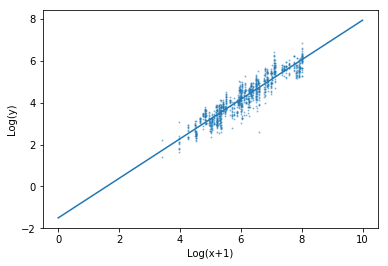

In [9]:
from scipy.stats import linregress

x = df['followed_by']
y = df['engagements']
slope, intercept, r_value, p_value, std_err = linregress(np.log10(x+1), np.log10(y))

xfid = np.linspace(0,10)

plt.scatter(np.log10(x+1), np.log10(y), marker="o", s=1, alpha=0.4)
plt.plot(xfid, xfid*slope+intercept)
plt.xlabel('Log(x+1)')
plt.ylabel('Log(y)')
plt.show()

### Experiment 1 (Features: Caption and Followers ---> Engagements)

In [10]:
exp1_dataset = pd.DataFrame(df[["engagements", 'followed_by', 'caption']])

**Vectorizing followers and caption**

In [11]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()

train_features  = []
for i, row in exp1_dataset.iterrows():
    train_features.append({"caption":row['caption'], "followed_by":row['followed_by']})
    
features = vec.fit_transform(train_features).toarray()
target = exp1_dataset['engagements']

**Splitting Dataset into 80:20**

In [20]:
split_ratio = 0.8

train_x = features[:int(len(features)*split_ratio)]
test_x = features[int(len(features)*split_ratio):]

train_y = target[:int(len(target)*split_ratio)]
test_y = target[int(len(target)*split_ratio):]

train_y.shape

(884,)

**Building Neural Net:**

In [ ]:
import tflearn
import tensorflow as tf


tf.reset_default_graph()

net = tflearn.input_data(shape=[None,len(train_x[0])], name='input')
net = tflearn.fully_connected(net, 200)
net = tflearn.fully_connected(net, 200)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.reshape(net,[-1])
net = tflearn.regression(net, name='targets')

model = tflearn.DNN(net)


model.fit({'input': train_x}, {'targets': train_y}, 
          validation_set=({'input': test_x}, {'targets': test_y}), 
           n_epoch=10000, batch_size=32, show_metric=True)

**Conclusion:**

The features (Followers and caption) are not sufficient to train a neural net to predict social engagements

### Experiment 2

In [2]:
from datetime import datetime
import dateutil
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import scipy
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading Dataset

In [5]:
ig_data = pd.read_csv('_data/raw/dataset.csv', sep=',', na_values='NaN')
y = ig_data["numberLikes"]

toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = ig_data.drop(toDrop,axis=1)

nonCat = ['localization']
processed = processed.drop(nonCat, axis=1)

**Convert website to categorical features**

In [6]:
processed['youtube']=processed['website'].str.contains("youtube|youtu", na=False).astype(int)
processed['music']=processed['website'].str.contains("soundcloud|spoti", na=False).astype(int)
processed['tumblr']=processed['website'].str.contains("tumblr", na=False).astype(int)
processed['facebook']=processed['website'].str.contains("facebook", na=False).astype(int)
processed['blog']=processed['website'].str.contains("blog|wordpress", na=False).astype(int)
processed['twitter']=processed['website'].str.contains("twitter", na=False).astype(int)
processed['other']=processed['website'].str.contains(".", na=False).astype(int)

processed = processed.drop(['website'], axis=1)

**Convert multipleImage to int**

In [7]:
processed['multipleImage']=processed['multipleImage'].astype(int)

**Convert dates to days of week**

In [8]:
copy=processed["date"].copy()
for i in range(0, len(processed)):
    copy[i] = datetime.weekday((dateutil.parser.parse(processed["date"][i])))
processed["date"]=copy.astype(np.int64)

In [9]:
processed['ratio'] = processed['numberFollowers']/processed['numberLikes']

In [11]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=4)

cluster.fit(processed['numberFollowers'].values.reshape(-1,1), processed['numberLikes'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Experiment 3 (Regression)

In [11]:
%matplotlib inline
ig_data = pd.read_csv('_data/raw/dataset.csv', sep=',', na_values='NaN')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c685a3cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c699ea7b8>]], dtype=object)

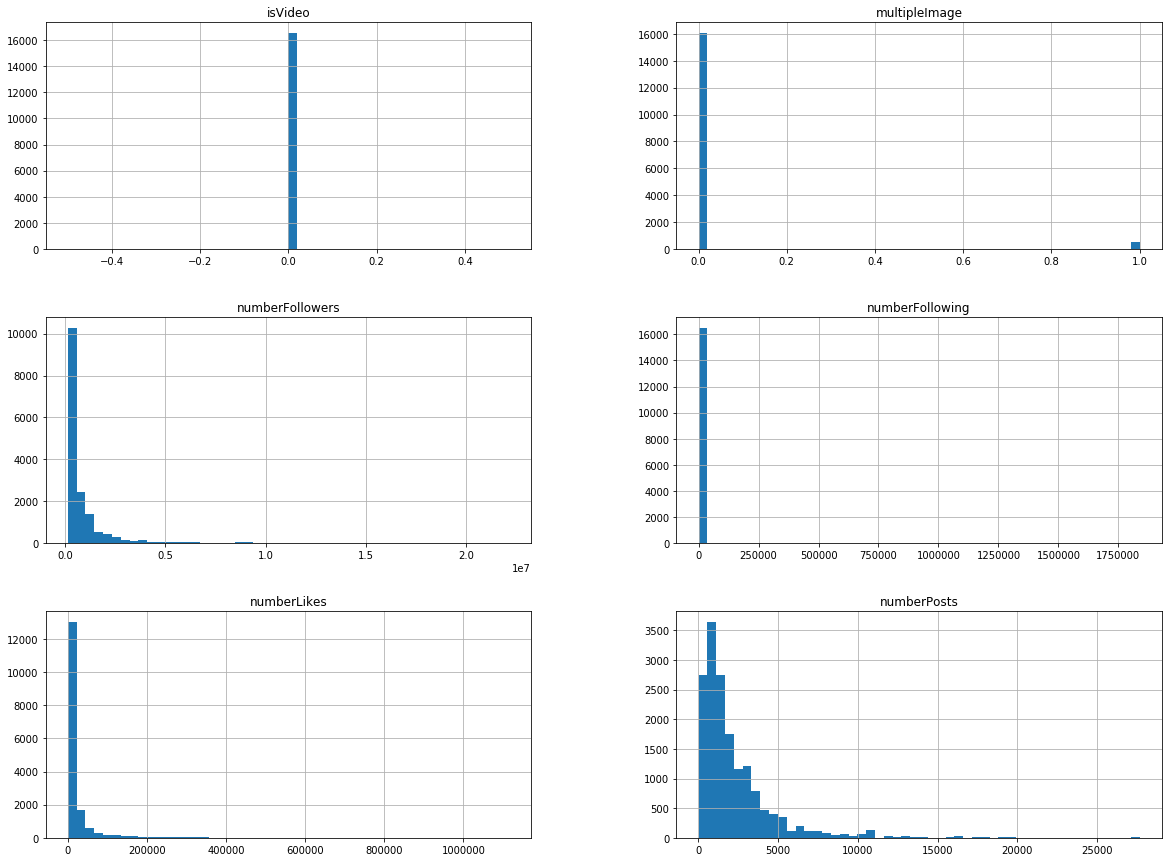

In [12]:
ig_data.hist(bins=50, figsize=(20,15))

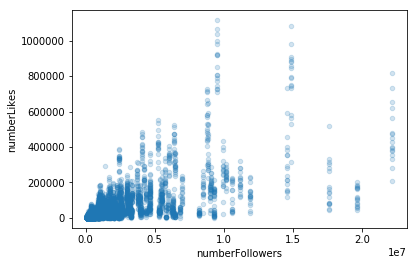

In [16]:
ig_data.plot(kind="scatter", x='numberFollowers', y='numberLikes', alpha="0.2")

In [18]:
ig_data.corr()

,numberPosts,numberFollowing,numberFollowers,multipleImage,isVideo,numberLikes
numberPosts,1.000000,-0.013493,0.232432,-0.010804,NaN,-0.002259
numberFollowing,-0.013493,1.000000,-0.008775,-0.005938,NaN,-0.008786
numberFollowers,0.232432,-0.008775,1.000000,-0.000231,NaN,0.689612
multipleImage,-0.010804,-0.005938,-0.000231,1.000000,NaN,-0.011641
isVideo,NaN,NaN,NaN,NaN,NaN,NaN
numberLikes,-0.002259,-0.008786,0.689612,-0.011641,NaN,1.000000


In [20]:
from pandas.tools.plotting import scatter_matrix

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c59c6b128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c5888a438>]], dtype=object)

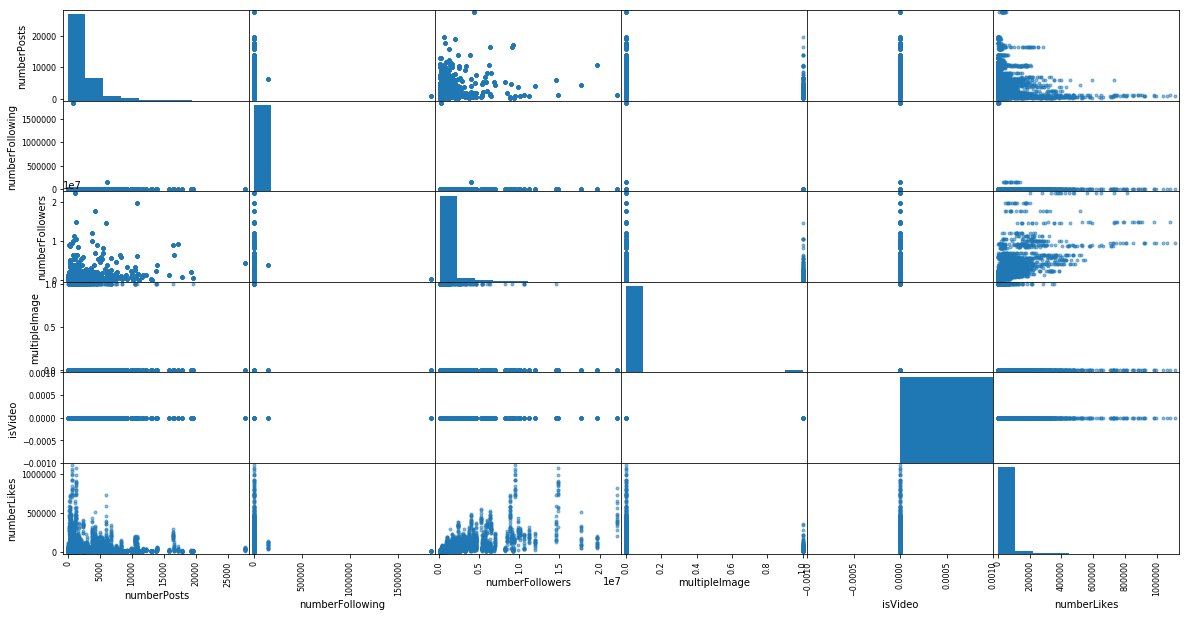

In [25]:
scatter_matrix(ig_data, figsize=(20, 10))

In [ ]:
to_consider = ['numberFollowers', ]